In [1]:
import fot_wrapper
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from parser.scenario import get_scenario
from parser.parser import Parser
import os
from commonroad.common.util import Interval
from typing import List
from commonroad.scenario.state import KSState, InitialState, PMState
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad.common.file_writer import CommonRoadFileWriter, OverwriteExistingFile
from commonroad.scenario.scenario import Tag
from parser.utils import create_trajectory_from_list_states, visualize_solution

In [2]:
scenario_name = '/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios/USA_US101-20_2_T-1.xml'
scenario, planning_problem, _ = get_scenario('', scenario_name)

In [3]:
int = planning_problem.goal.state_list[0].time_step
print(int.end)

80


In [4]:
start = planning_problem.initial_state.position
    # print(start)
parser = Parser(scenario=scenario, planning_problem=planning_problem,\
                  x_interval=Interval(0, 125), y_interval=Interval(0, 125))
# _, obstacles_d = filter_obstacles(scenario=scenario, x_interval=Interval(-40, 40), y_interval=Interval(-80, 40))
vel_int = planning_problem.goal.state_list[0].velocity
vel = (vel_int.start + vel_int.end) / 2
# print(vel)

goal = planning_problem.goal.state_list[0].position.center
EPS = 3
LENGTH = 11
      
conds = {
      's0': parser.parse_initial_position(x_only=True),
      'target_speed': 15,
      'wp': parser.parse_waypoints(initial_state=start, goal_state=goal),
      'obs': parser.parse_obstacles(time_step=0),
      'pos': parser.parse_initial_position(x_only=False),
      'vel': [2, -2],
} # paste output from debug log

initial_conditions = {
      'ps': conds['s0'],
      'target_speed': conds['target_speed'],
      'pos': np.array(conds['pos']),
      'vel': np.array(conds['vel']),
      'wp': np.array(conds['wp']),
      'obs': np.array(conds['obs'])
}

hyperparameters = {
      "max_speed": 30.0,
      "max_accel": 20.0,  # was 15
      "max_curvature": 15.0,
      "max_road_width_l": 10.0,  # was 5
      "max_road_width_r": 12.0,  # was 5
      "d_road_w": 0.5, # was 0.5
      "dt": 0.2,
      "maxt": 5.0, # was 5
      "mint": 2.0, # was 2
      "d_t_s": 0.2,
      "n_s_sample": 50.0,
      "obstacle_clearance": 0.2,
      "kd": 1.0,
      "kv": 0.1,
      "ka": 0.1,
      "kj": 0.1,
      "kt": 0.1,
      "ko": 0.1,
      "klat": 1.0,
      "klon": 1.0
}
# static elements of planner
wx = initial_conditions['wp'][:, 0]
wy = initial_conditions['wp'][:, 1]
w = initial_conditions['wp']
obs = np.array(conds['obs'])

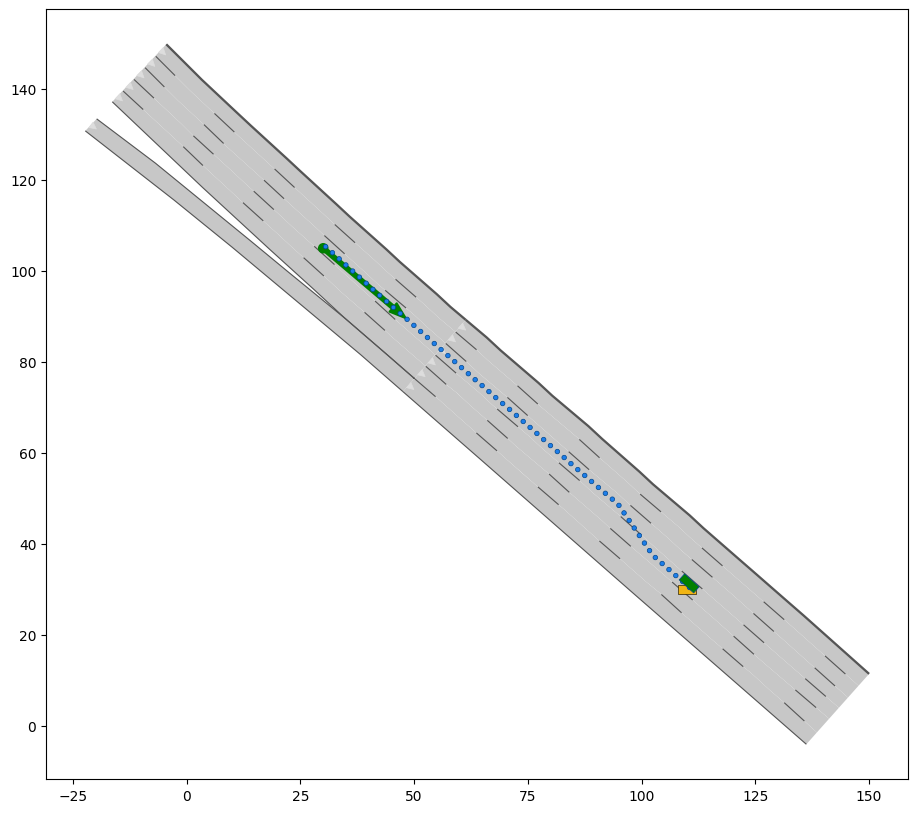

Goal Reached


In [5]:
for i in range(100):
      print("loop: ", i)
      result_x, result_y, speeds, ix, iy, iyaw, d, s, speeds_x, \
                  speeds_y, misc, costs, success = fot_wrapper.run_fot(initial_conditions, hyperparameters)
                  
      if i == 0:
            states_list: List[List[PMState]] = [[PMState(time_step=j, position=np.array([result_x[j], result_y[j]]),\
                                                velocity=speeds_x[j], velocity_y=speeds_y[j])] for j in range(len(result_x[:LENGTH]))]
      else:
            states_list: List[List[PMState]] = [[PMState(time_step=states_list[-1][0].time_step+1+j, position=np.array([result_x[j], result_y[j]]),\
                                                velocity=speeds_x[j], velocity_y=speeds_y[j])] for j in range(len(result_x[:LENGTH]))]
      
      trajectory = create_trajectory_from_list_states(states_list)
      
      # print(misc)
      # print("ix: ", ix, "\n\n", "iy: ", iy, "\n\n", "iyaw: ", iyaw, "\n\n")
      # print("ix: ", d, "\n\n")
      # print("result_x: ", s, "\n\n")
      
      # for state in trajectory.state_list:
      #       print(state)
      
      visualize_solution(scenario=scenario, planning_problem_set=planning_problem, trajectory=trajectory, waypoints=w, c=i)
      # print("True" if success else "False")
      
      if success:
            if np.abs(result_x[-1] - goal[0]) < EPS and np.abs(result_y[-1] - goal[1]) < EPS:
                print("Goal Reached")
                break
            
            initial_conditions['pos'] = np.array([result_x[LENGTH-1], result_y[LENGTH-1]])
            initial_conditions['vel'] = np.array([speeds_x[LENGTH-1], speeds_y[LENGTH-1]])
            initial_conditions['ps'] = misc['s']
            initial_conditions['obs'] = np.array(parser.parse_obstacles(time_step=(i+1)*LENGTH))
            obs = initial_conditions['obs']
            # print(obs)
            # print(costs)
      else:
            print("Failed unexpectedly")
            break


In [6]:
states_list[-1][0].time_step

92

In [7]:
trajectory.state_list[-1].time_step

92